# Empirical Risk Minimization (ERM)

Empirical Risk Minimization (ERM) is a Bayesian inference technique used to make "optimal" decisions about new data based on labelled data we have previously seen. This is explicitly achieved by selecting decisions that result in the <b>smallest expected risk</b>.

Imports for this notebook:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Gaussian Mixture Model Setting

Mixture models have the form:

$$ p(\mathbf{x}) = \sum_{c=1}^C a_c p_c(\mathbf{x}). $$

These models are a linear combination of multiple component distributions, where $p_c(\mathbf{x})$ is the $c^{th}$ probability density function (pdf), and $a_c$ is the $c^{th}$ "mixture weight", such that both $0 \leq a_c \leq 1$ and $\sum_{c=1}^C a_c = 1$ are satisfied.

Let's look at the concrete example of a Gaussian Mixture Model (GMM), where $p_c(\mathbf{x}) = \mathcal{N}(\mathbf{x} \,|\, \boldsymbol{\mu}_c, \boldsymbol{\Sigma}_c)$ for $c \in \{1, ..., C\}$, with each $c^{th}$ component distribution represented as a multivariate Gaussian. Effectively, we are "choosing" a Gaussian pdf to sample from based on the weights $a_c$. Please refer to Chpt. 3.5 of Murphy's 2022 book for a more formal review.

Below provides an example of how to draw samples using the SciPy library, notably the `scipy.stats` module and its `multivariate_normal` class. It also defines the dataset setting for our ERM demonstration, which consists of the following conditional log-likelihoods for 3 classes with true labels $L$:

$$ p(\mathbf{x} \,|\, L=0) = \mathcal{N}(\mathbf{x} \,|\, \boldsymbol{\mu}_{0}, \boldsymbol{\Sigma}_{0}),$$
$$ p(\mathbf{x} \,|\, L=1) = \mathcal{N}(\mathbf{x} \,|\, \boldsymbol{\mu}_{1}, \boldsymbol{\Sigma}_{1}),$$
$$ p(\mathbf{x} \,|\, L=2) = \mathcal{N}(\mathbf{x} \,|\, \boldsymbol{\mu}_{2}, \boldsymbol{\Sigma}_{2}),$$

where we have 3 multivariate Gaussian class-conditionals, each with their own respective mean vectors and covariance matrices. Assume our class priors are $p(L=0)=0.2$, $p(L=1)=0.5$ and $p(L=2)=0.3$. Using a GMM, we will assume the following parameters for the class-conditionals:

\begin{equation*}
    \boldsymbol{\mu}_0=\begin{bmatrix} 1\\4 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_0=\begin{bmatrix}1 & -1.5 \\-1.5 & 3 \end{bmatrix}, ~~~
    \boldsymbol{\mu}_1=\begin{bmatrix} -10\\-2 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_1=\begin{bmatrix}2 & 1.5 \\1.5 & 8 \end{bmatrix}, ~~~
    \boldsymbol{\mu}_2=\begin{bmatrix} 3\\10 \end{bmatrix} ~~~
    \boldsymbol{\Sigma}_2=\begin{bmatrix}4 & 2.5 \\2.5 & 4 \end{bmatrix}, \\
\end{equation*}

illustrating that we have 2-dimensional bivariate Gaussian component distributions. Let's generate this data and color-code the individual components based on their labels:

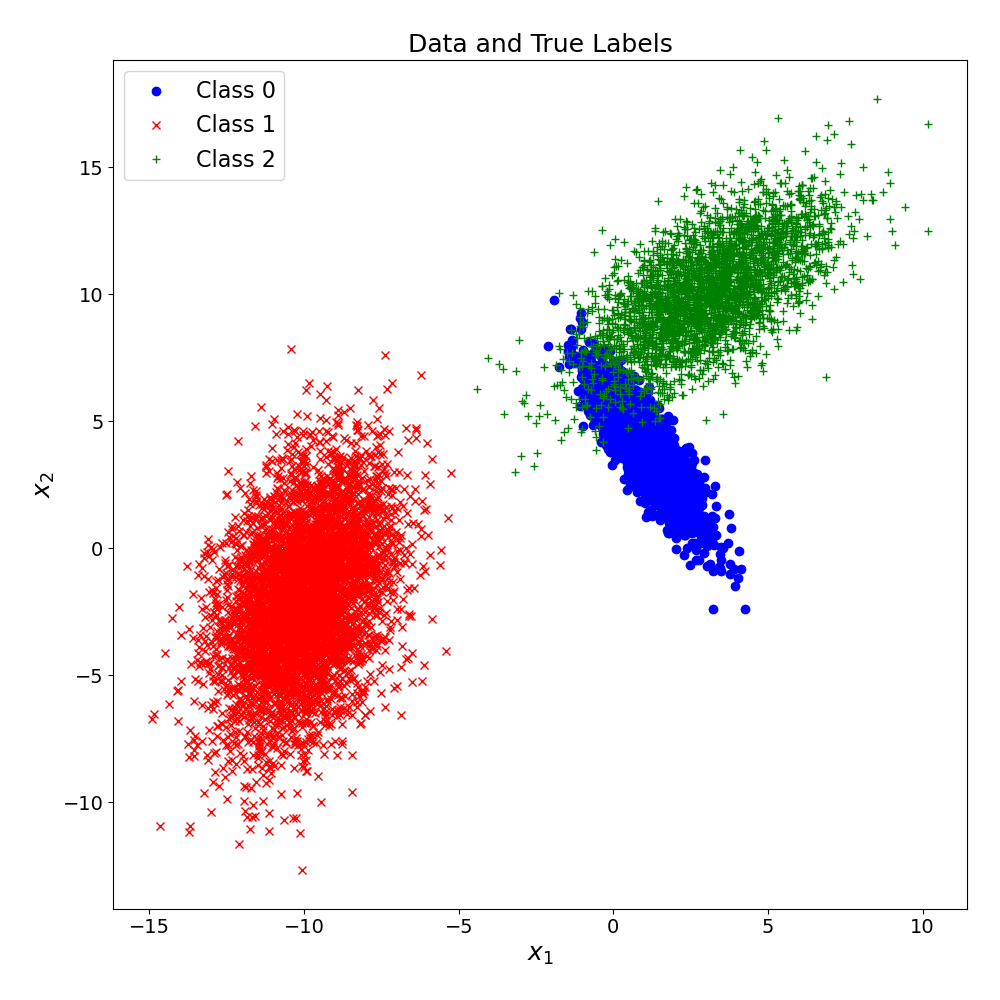

In [2]:
# Number of samples to draw from each distribution
N = 10000

# Likelihood of each distribution to be selected AND class priors!!!
priors = np.array([0.2, 0.5, 0.3])  
# Determine number of classes/mixture components
C = len(priors)
mu = np.array([[1, 4],
               [-10, -2],
               [3, 10]])  # Gaussian distributions means
Sigma = np.array([[[1, -1.5],
                   [-1.5, 3]],
                  [[2, 1.5],
                   [1.5, 8]],
                  [[4, 2.5],
                   [2.5, 4]]])  # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]
# Output samples and labels
X = np.zeros([N, n])
labels = np.zeros(N)

# Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
u = np.random.rand(N)
# Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
thresholds = np.cumsum(priors)

for c in range(C):
    c_ind = np.argwhere(u <= thresholds[c])[:, 0]  # Get randomly sampled indices for this component
    c_N = len(c_ind)  # No. of samples in this component
    labels[c_ind] = c * np.ones(c_N)
    u[c_ind] = 1.1 * np.ones(c_N)  # Multiply by 1.1 to fail <= thresholds and thus not reuse samples
    X[c_ind, :] =  multivariate_normal.rvs(mu[c], Sigma[c], c_N)

# Plot the original data and their true labels
plt.figure(figsize=(10, 10))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'bo', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'rx', label="Class 1");
plt.plot(X[labels==2, 0], X[labels==2, 1], 'g+', label="Class 2");
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.tight_layout()
plt.show()

## ERM Classification using True Knowledge of PDF

For this demo of ERM, we are specifically going to use <b>0-1 loss</b>, such that the decision rule we wish to derive achieves minimum probability of error, i.e. the <b> maximum a posteriori (MAP)</b> classification rule. We will implement this classifier with the true distribution knowledge we have outlined above, and count samples per decision-label pair to produce a confusion matrix with entries $p(D=i\,|\,L=j)$ for $i,j \in \{0, 1, 2\}$ 

In [3]:
L = np.array(range(C))  # 0-(C-1)

The decision rule that achieves minimum probability of error uses a loss matrix $\mathbf{\Lambda}$ with entries $\lambda_{ij} = 1 - \delta_{ij}$ where $\lambda_{ij}$ is the loss associated with deciding class label $i$ given $\mathbf{x}$ comes from class label $j$ and $\delta_{ij}$ is the Kronecker delta: 

$$\lambda_{ij} =
    \begin{cases}
        0  & \text{if} \; i = j \\
         1 & \text{if} \; i \neq j
    \end{cases}
$$

From this, we can define the following 0-1 loss matrix:

$$ \mathbf{\Lambda} = \begin{bmatrix} 0 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 0  \end{bmatrix}. $$

In [4]:
# We are going to use a 0-1 loss matrix for this problem
Lambda = np.ones((C, C)) - np.identity(C)
print(Lambda)

[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


For a given $\mathbf{x}$, we want to choose a class label $i$ which minimizes risk (or loss) associated with choosing this class label. Hence, we need a decision rule $D(\mathbf{x})$, which is a function $D : \mathbb{R}^n \rightarrow {1, \ldots, C} \in \mathbb{Z}$ that tells us which action to take or decision to make for every possible observation.

We know that the ERM decision rule $D(\mathbf{x})$ is based on minimizing conditional risk, defined as:

$$ D(\mathbf{x}) = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} R(D = i \, | \, \mathbf{x}) = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} \sum_{j=0}^2 \lambda_{ij} p(L = j \, | \, \mathbf{x}).$$

In the case of a 0-1 loss function $\lambda_{ij}$, then:

\begin{align*}
R(D = i \, | \, \mathbf{x}) 
& = \sum_{j=0}^2 \lambda_{ij} p(L = j \, | \, \mathbf{x}) \\
& = \sum_{j \neq i} p(L = j \, | \, \mathbf{x}) \\
& = 1 - p(L = i \, | \, \mathbf{x}).
\end{align*}

As a result, the decision rule $D(\mathbf{x})$ ends up <b>minimizing the average probability of error</b> (misclassification rate or posterior expected loss):

\begin{align*}
 D(\mathbf{x}) & = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} R(D = i \, | \, \mathbf{x}) \\ 
               & = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} 1 - p(L = i \, | \, \mathbf{x}) \\
               & = \mathop{\rm argmax}_{i\in \{0, 1, 2\}} p(L = i \, | \, \mathbf{x}),
\end{align*}

or equivalently, as shown in the last step, computing the <b>MAP estimate</b>.

While we have just derived the ERM decision rule <i>without</i> needing a loss matrix $\boldsymbol{\Lambda}$ due to the 0-1 loss setting, I will still proceed with its application for sake of generality.

In particular, I wish to break down $D(\mathbf{x})$ in the code by first converting the risk $R(D = i \, | \, \mathbf{x})$ of choosing decision $i$ given observation $\mathbf{x}$ into matrix form (see extra notes):

$$ \begin{bmatrix} R(D=0\, | \,\mathbf{x}) \\  R(D=1\, | \,\mathbf{x}) \\ R(D=2\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \begin{bmatrix} p(L=0\, | \,\mathbf{x}) \\ p(L=1\, | \,\mathbf{x}) \\ p(L=2\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \, \text{diag}\big(p(L=0), p(L=1), p(L=2) \big) \begin{bmatrix} p(\mathbf{x}\, | \,L=0) \\ p(\mathbf{x}\, | \,L=1) \\ p(\mathbf{x}\, | \,L=2) \end{bmatrix}.$$

The LHS of this equality is the risk across all decision options, and the RHS of the equality is the loss matrix and class posteriors, which have been expanded using Bayes rule into likelihood and prior terms. Therefore we can proceed in the code by computing the class posteriors from the priors and conditional likelihoods:

In [5]:
# Calculate class-conditional likelihoods p(x|L=j) for each label of the N observations
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[j], Sigma[j]) for j in L])
class_priors = np.diag(priors)

# Matrix of posteriors, shaped [C, N]
class_posteriors = class_priors.dot(class_cond_likelihoods)

And then the conditional risk scores using $\boldsymbol{\Lambda}$, which again I emphasize is not required for 0-1 loss but demonstrates the full ERM framework:

In [6]:
# We want to create the risk matrix of size C x N
cond_risk = Lambda.dot(class_posteriors)

This finally leaves us with our decision vector for all observations:

$$ D(\mathbf{x}) = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} R(D = i \, | \, \mathbf{x}). $$

In [7]:
# Get the decision for each column in risk_mat
decisions = np.argmin(cond_risk, axis=0)

We can now yield the following <b>normalized</b> confusion matrix over the true columns (class sample counts):
    
$$ \begin{bmatrix} p(D=0\, | \,L=0) & \cdots & p(D=2\, | \,L=0) \\ \vdots & \ddots & \vdots \\  p(D=0\, | \,L=2) & \cdots & p(D=2\, | \,L=2)  \end{bmatrix}. $$

And reminder that the <b>probability of error</b> is:

$$ \text{Pr}(\text{error}) = 1 - \text{Pr}(\text{correct}) = 1 - \frac{1}{N}\sum_i^2 N_i p(D = i \,|\, L = i),$$

with $N_i$ as the number of samples belonging to class $i$. So the final minimum probability of error estimate using our MAP classifier is computed by:

Confusion matrix:
[[0.98424421 0.         0.03062583]
 [0.         1.         0.        ]
 [0.01575579 0.         0.96937417]]
Minimum Probability of Error:  0.012399999999999967


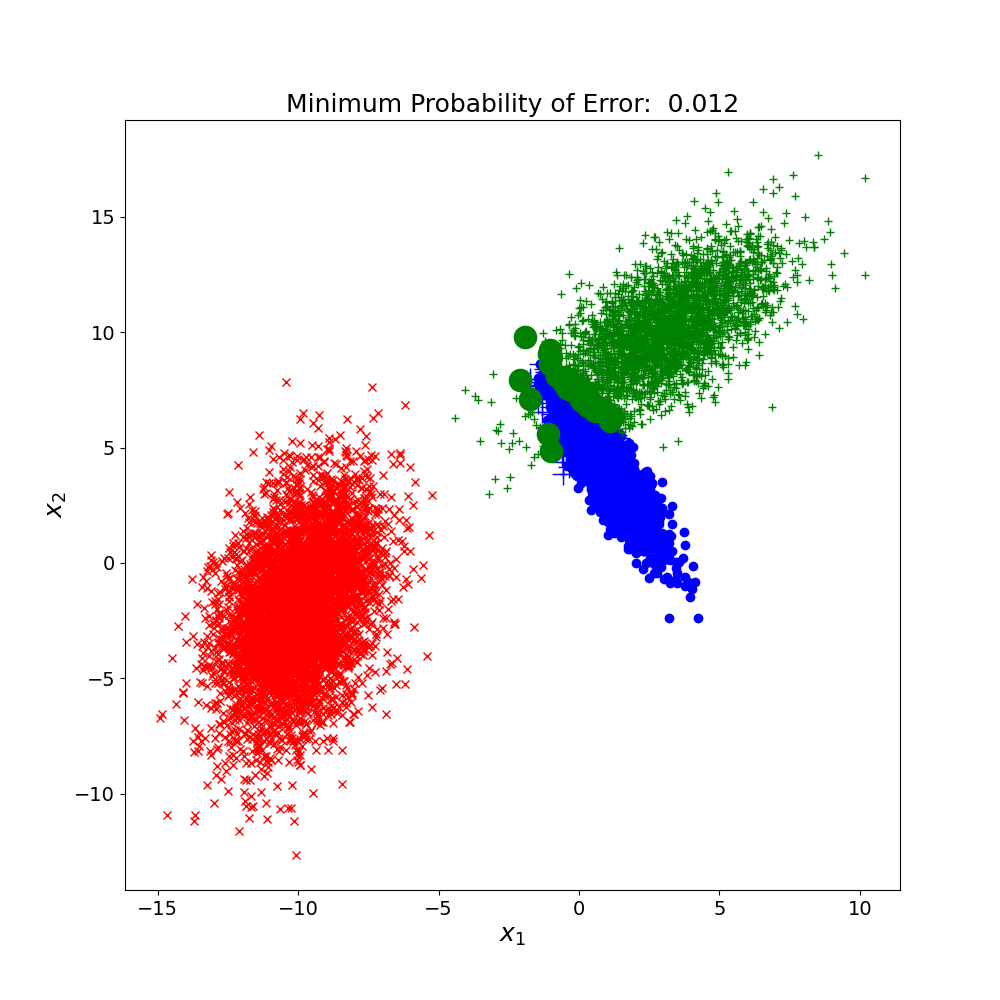

In [8]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = 'ox+*.' # Accomodates up to C=5
marker_colors = 'brgmy'

# Get sample class counts
sample_class_counts = np.array([sum(labels == j) for j in L])

# Confusion matrix compute from scratch
conf_mat = np.zeros((C, C))
for i in L: # Each decision option
    for j in L: # Each class label
        ind_ij = np.argwhere((decisions==i) & (labels==j))
        conf_mat[i, j] = len(ind_ij) / sample_class_counts[j] # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        marker = marker_shapes[j] + marker_colors[i]
        plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker)

        if i != j:
            plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker, markersize=16)
            
print("Confusion matrix:")
print(conf_mat)

# # Can also compute the normalized confusion matrix from scikit-learn's method
# from sklearn.metrics import confusion_matrix
# print("Normalized Sklearn Confusion Matrix (column basis):")
# conf_mat = confusion_matrix(decisions, labels, normalize='pred')
# print(conf_mat)

prob_error = 1 - np.diag(conf_mat).dot(sample_class_counts) / N
print("Minimum Probability of Error: ", prob_error)

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Minimum Probability of Error:  {:.3f}".format(prob_error))
plt.show()